In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ete3 import Tree, ProfileFace, TreeStyle, BarChartFace

# Load the list of COGs

In [2]:
WLP = pd.read_csv("../Data/input/AllWLPGenes.csv", sep =";", comment = "#", header = 0).iloc[:,[0,1,2,7,8]]
WLP = WLP.loc[WLP.Used == True, ["Category","Group","GeneName","COG"]]
WLP["COGName"] = WLP.GeneName+" ("+WLP.COG+")"
WLP

,Category,Group,GeneName,COG,COGName
0,Metabolic,THMPT,FmdC,COG2218,FmdC (COG2218)
1,Metabolic,THMPT,Ftr,COG2037,Ftr (COG2037)
2,Metabolic,THMPT,Mch,COG3252,Mch (COG3252)
3,Metabolic,THMPT,Mtd,COG1927,Mtd (COG1927)
4,Metabolic,THMPT,Hmd,COG4007,Hmd (COG4007)
...,...,...,...,...,...
77,Ion-translocating,ECH,EhbD/MbhD,COG1563,EhbD/MbhD (COG1563)
78,Ion-translocating,ECH,EhbE/MbhG,COG1006,EhbE/MbhG (COG1006)
79,Ion-translocating,ECH,EhbH/I/MbhE/F,COG2111,EhbH/I/MbhE/F (COG2111)
80,Ion-translocating,ECH,EhbL/MbhN,COG1143,EhbL/MbhN (COG1143)


# Retrieve the gene counts from the Orthofinder results

In [3]:
emapper = pd.read_csv("../Data/input/MM_jbrjl6fg.emapper.annotations.tsv", sep ="\t", comment = "#", header = None)
emapper.columns = ["query","seed_ortholog","evalue","score","eggNOG_OGs","max_annot_lvl","COG_category","Description","Preferred_name","GOs","EC","KEGG_ko","KEGG_Pathway","KEGG_Module","KEGG_Reaction","KEGG_rclass","BRITE","KEGG_TC","CAZy","BiGG_Reaction","PFAMs"]

OFOGs = pd.read_csv("../Data/input/Proteomes/OrthoFinder/Results_Dec03/Orthogroups/Orthogroups.GeneCount.tsv", sep ="\t", comment = "#", index_col = 0, header = 0)

OFOG_Annot = pd.DataFrame()
OFOG_Annot["OFOG"] = emapper["query"].str.split(".",expand=True)[0]
OFOG_Annot["COG"] = emapper["eggNOG_OGs"].str.split("@",expand=True)[0]
OFOG_Annot.head()

,OFOG,COG
0,OG0000000,KOG0084
1,OG0000001,COG1136
2,OG0000003,COG1131
3,OG0000005,COG1028
4,OG0000006,COG2414


In [4]:
WLP_genes = WLP.COG.loc[WLP.COG.isin(OFOG_Annot.COG)]

WLP_genes_OFOGs = OFOG_Annot.set_index("COG").loc[WLP_genes.values]
WLP_genes_OFOGs.head()

,OFOG
COG,
COG2218,OG0001105
COG2037,OG0000363
COG3252,OG0000500
COG1927,OG0001166
COG2141,OG0000041


In [5]:
WLP_OFOGs_Count = OFOGs.loc[WLP_genes_OFOGs.OFOG.values].reset_index().merge(WLP_genes_OFOGs.reset_index(), how= "left", left_on="Orthogroup", right_on="OFOG").set_index("Orthogroup").drop(["Total","OFOG"], axis=1)
WLP_OFOGs_Count = WLP_OFOGs_Count.drop_duplicates()

COGsSpOI = WLP_OFOGs_Count.groupby(['COG']).sum()
COGsSpOI.head()

,UP000070043,UP000070149,UP000070599,UP000185561,UP000186063,UP000186209,UP000186239,UP000186851,UP000228988,UP000245584,...,UP000751408,UP000760201,UP000771954,UP000775429,UP000777023,UP000825566,UP000825906,UP000826397,UP000826686,UP000826833
COG,,,,,,,,,,,,,,,,,,,,,
COG0190,1,1,0,1,1,1,1,0,0,0,...,1,1,1,1,1,1,1,1,1,1
COG0374,2,2,1,2,2,1,0,1,0,0,...,2,2,3,3,2,2,1,2,1,3
COG0493,4,1,0,2,1,1,0,0,0,3,...,3,3,3,1,5,3,1,3,1,2
COG0543,5,3,2,3,1,1,3,2,1,4,...,4,3,5,4,3,3,1,3,2,3
COG0644,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0


## Calculate median count per taxonomic sub group

In [6]:
ProposedClass = pd.read_csv("../Data/input/ProposedClassification.csv", sep =",", comment = "#", header = 0, index_col = "UPID")#["Organism"]
data = COGsSpOI.T.merge(ProposedClass, how = "left", left_index=True, right_index=True)#.groupby(["Group"])
COGs_ByGenus = data.groupby(data.iloc[:,-1]).median().T
COGs_ByGenus.head()

/var/folders/qr/vm827mh53sd6708z2k3_tnnrz3fj08/T/ipykernel_52454/4041458824.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  COGs_ByGenus = data.groupby(data.iloc[:,-1]).median().T


Group,Heimdall 1,Heimdall 2,Heimdall 3,Heimdall 4,Heimdall 5,Loki 1,Loki 2,Loki 3,Loki 4,Loki 5,Odin,Thor
COG0190,0.5,1.0,1.0,1.0,0.0,1.0,0.5,0.0,0.5,1.0,0.0,1.0
COG0374,0.5,2.0,1.0,1.5,2.0,2.0,2.0,1.5,1.0,2.0,1.0,2.0
COG0493,0.5,1.0,2.0,0.5,4.0,3.0,0.5,0.0,1.5,1.5,0.0,2.0
COG0543,1.0,1.0,3.0,3.5,6.0,3.0,2.5,0.0,2.5,3.0,2.0,3.0
COG0644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0


# Retrieve the gene counts from eggNOG

In [7]:
Root_OGMembers = pd.read_csv("../Data/input/EggNOG/1_members.tsv", sep ="\t", comment = "#", header = None, index_col = 1)

# Keep only the relevant rows, with COG related to BFEB
Root_OGs = Root_OGMembers[Root_OGMembers.index.isin(WLP.COG)]

#Restructure to a count matrix
Root_OGs["list"] = Root_OGs[4].str.split(",", expand = False)
Root_OGs = Root_OGs["list"].explode().str.split(".", expand = True, n=1)#.reset_index(name = "COG")
Root_OGs.columns = ["species","gene"]
Root_OGs = Root_OGs.reset_index()
Root_OGs.columns = ["COG","species","gene"]
Root_OG_Counts = Root_OGs.groupby(["COG","species"]).count().unstack().fillna(0)
Root_OG_Counts.columns = Root_OG_Counts.columns.droplevel(0)

#Subset to the chosen reference species
NCBIRefIDs = pd.read_csv("../Data/input/EggNOG/NCBIRefIDs.tsv", sep ="\t", comment = "#", header = None)
NCBIRefIDs.columns = ["TaxID", "TaxName"]
NCBIRefIDs = NCBIRefIDs.astype(str).set_index("TaxID").iloc[:-3]

COGsRefSp = Root_OG_Counts[NCBIRefIDs.index]
COGsRefSp.head()

/var/folders/qr/vm827mh53sd6708z2k3_tnnrz3fj08/T/ipykernel_52454/3814293139.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Root_OGs["list"] = Root_OGs[4].str.split(",", expand = False)


species,574087,931626,264732,33035,1123288,903814,748727,545694,903818,243232,426368,192952,323259,304371,410358,456320,419665,339860
COG,,,,,,,,,,,,,,,,,,
COG0190,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
COG0243,1.0,1.0,6.0,1.0,9.0,0.0,3.0,2.0,5.0,1.0,2.0,0.0,6.0,2.0,2.0,2.0,1.0,1.0
COG0282,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
COG0374,1.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,2.0,2.0,4.0,1.0,5.0,1.0,4.0,3.0,2.0
COG0493,1.0,8.0,4.0,6.0,3.0,2.0,9.0,2.0,5.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


# Combine OrthoFinder and EggNOG matrices

In [8]:
COGs = COGsRefSp.merge(COGs_ByGenus, how= "outer", left_on=None, right_on=None, left_index=True, right_index=True).fillna(0)

# Reformat by genes as rows

In [9]:
WLP_Genes = WLP.merge(COGs, how = "left", left_on="COG", right_index= True).set_index("COGName").drop(["GeneName","Category","Group","COG"],axis=1).fillna(0)
WLP_Genes.head()

,574087,931626,264732,33035,1123288,903814,748727,545694,903818,243232,...,Heimdall 3,Heimdall 4,Heimdall 5,Loki 1,Loki 2,Loki 3,Loki 4,Loki 5,Odin,Thor
COGName,,,,,,,,,,,,,,,,,,,,,
FmdC (COG2218),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,1.0,1.0,0.5,0.5,0.0,1.0,1.0,1.0
Ftr (COG2037),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,2.0,3.0,2.0,0.5,1.0,2.0,2.0,1.0
Mch (COG3252),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,2.0,1.0,0.5,0.5,0.5,1.0,1.0,1.0
Mtd (COG1927),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.5,1.0,1.0,0.5,0.5,0.0,1.0,1.0,1.0
Hmd (COG4007),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
SpeciesIndexDF = pd.read_csv("../Data/input/SpeciesIndexDF.tsv", sep ="\t", comment = "#", header = 0, index_col = "Proteome Id")["Organism"]
SpNamesID = pd.concat([SpeciesIndexDF,NCBIRefIDs["TaxName"]])
SpNamesID

UP000321408       Ca. Prometheoarchaeum syntrophicum
UP000070043      Ca. Thorarchaeota archaeon SMTZ1-83
UP000070149      Ca. Thorarchaeota archaeon SMTZ1-45
UP000070599       Ca. Thorarchaeota archaeon SMTZ-45
UP000185561    Thorarchaeota archaeon (strain AB_25)
                               ...                  
304371                       Methanocella paludicola
410358                  Methanocorpusculum labreanum
456320                          Methanococcus voltae
419665                        Methanococcus aeolicus
339860                     Methanosphaera stadtmanae
Length: 86, dtype: object

/var/folders/qr/vm827mh53sd6708z2k3_tnnrz3fj08/T/ipykernel_52454/1111412580.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LeavesToKeep["Feature"] = LeavesToKeep["TaxName"]


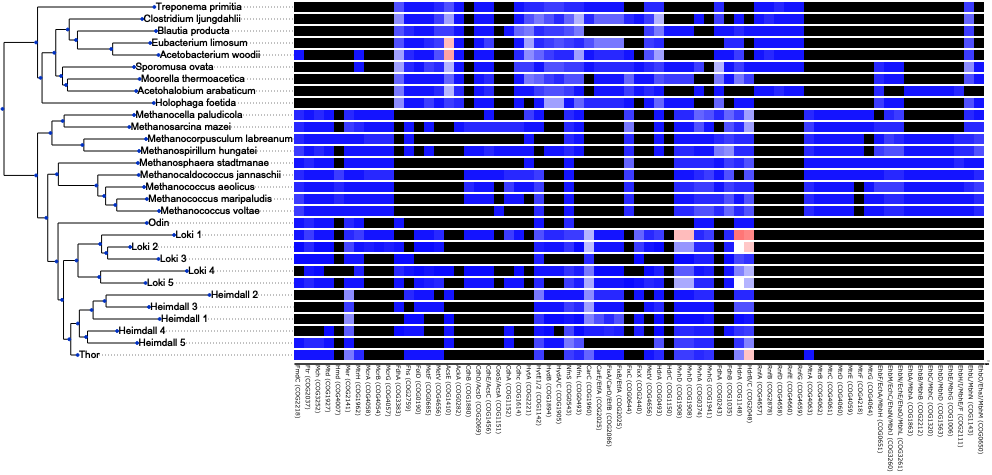

In [11]:
Combined = Tree("../Data/input/CombninedSpeciesTreeETE.nw", format=1)# made using orthofinder, NCBI ID's are slightly different to the ones from the strains in EggNOG so that's corrected in the .nw file.
Combined.ladderize()

LeavesToKeep = ProposedClass[~ProposedClass.iloc[:,0].duplicated()]
LeavesToKeep.columns = ["TaxName"]
Combined.prune(NCBIRefIDs.index.union(LeavesToKeep.index))

#Add columns to link to the count matrix
LeavesToKeep["Feature"] = LeavesToKeep["TaxName"]
NCBIRefIDs["Feature"] = NCBIRefIDs.index

# Combine into single indexing dataframe
SpNamesID = pd.concat([LeavesToKeep,NCBIRefIDs])

# Rename the Asgard leaves so that they match the median counts instead of the chosen species
for lf in Combined.iter_leaves():
    if lf.name in list(LeavesToKeep.index):
        lf.name = LeavesToKeep.loc[lf.name][0]

BranchOrder = Combined.get_leaf_names()
        
# Add the counts to the specific leaves of the tree and change the names from TaxID to actual names
for lf in Combined.iter_leaves():
    lf.add_features(profile = WLP_Genes[lf.name].values)
    lf.add_features(deviation = [0 for x in range(len(WLP_Genes))])
    lf.add_face(ProfileFace(max_v=36.0, min_v=0.0, center_v=10.0, style='heatmap', colorscheme=4, width=len(WLP_Genes)*10, height=10), column=0, position="aligned")
    lf.name = SpNamesID.set_index("Feature")["TaxName"][lf.name]

description = list(WLP_Genes.index)
axisface = BarChartFace([0]*len(list(WLP_Genes.index)), width=len(WLP_Genes)*10, height=0, labels=list(WLP_Genes.index), max_value=1, scale_fsize=1)

ts = TreeStyle()
ts.draw_guiding_lines = True
ts.show_leaf_name = True
ts.aligned_foot.add_face(axisface, 0)
ts.show_scale = False

#Combined.render('../Data/output/heatmap.png', tree_style=ts, dpi = 75)
Combined.render("%%inline",tree_style=ts, dpi = 75)

# Plot again, separately for each category (Metabolic/Bifurcating/Translocating)

/var/folders/qr/vm827mh53sd6708z2k3_tnnrz3fj08/T/ipykernel_52454/1983209250.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LeavesToKeep["Feature"] = LeavesToKeep["TaxName"]


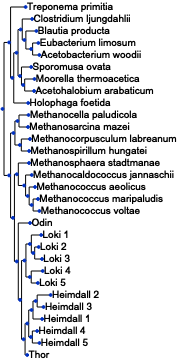

In [12]:
Combined = Tree("../Data/input/CombninedSpeciesTreeETE.nw", format=1)# made using orthofinder, NCBI ID's are slightly different to the ones from the strains in EggNOG so that's corrected in the .nw file.
Combined.ladderize()

LeavesToKeep = ProposedClass[~ProposedClass.iloc[:,0].duplicated()]
LeavesToKeep.columns = ["TaxName"]
Combined.prune(NCBIRefIDs.index.union(LeavesToKeep.index))

#Add columns to link to the count matrix
LeavesToKeep["Feature"] = LeavesToKeep["TaxName"]
NCBIRefIDs["Feature"] = NCBIRefIDs.index

# Combine into single indexing dataframe
SpNamesID = pd.concat([LeavesToKeep,NCBIRefIDs])

# Rename the Asgard leaves so that they match the median counts instead of the chosen species
for lf in Combined.iter_leaves():
    if lf.name in list(LeavesToKeep.index):
        lf.name = LeavesToKeep.loc[lf.name][0]

BranchOrder = Combined.get_leaf_names()
        
# Add the counts to the specific leaves of the tree and change the names from TaxID to actual names
for lf in Combined.iter_leaves():
    lf.name = SpNamesID.set_index("Feature")["TaxName"][lf.name]

description = list(WLP_Genes.index)
axisface = BarChartFace([0]*len(list(WLP_Genes.index)), width=len(WLP_Genes)*10, height=0, labels=list(WLP_Genes.index), max_value=1, scale_fsize=1)

ts = TreeStyle()
ts.draw_guiding_lines = True
ts.show_leaf_name = True
ts.aligned_foot.add_face(axisface, 0)
ts.scale =  20
ts.show_scale = False

#Combined.render('../Data/output/heatmap.png', tree_style=ts, dpi = 75)
Combined.render("%%inline",tree_style=ts, dpi = 75)

In [13]:
WLP.COGName.iloc[::-1].values

array(['EhbO/EhaJ/MbhM (COG0650)', 'EhbL/MbhN (COG1143)',
       'EhbH/I/MbhE/F (COG2111)', 'EhbE/MbhG (COG1006)',
       'EhbD/MbhD (COG1563)', 'EhbC/MbhC (COG1320)',
       'EhbB/MbhB (COG2212)', 'EhbA/MbhA (COG1863)',
       'EhbN/EchE/EhaO/MbhL (COG3261)', 'EhbM/EchC/EhaN/MbhJ (COG3260)',
       'EhbF/EchA/MbhH (COG0651)', 'MtrG (COG4064)', 'MtrF (COG4218)',
       'MtrE (COG4059)', 'MtrD (COG4060)', 'MtrC (COG4061)',
       'MtrB (COG4062)', 'MtrA (COG4063)', 'RnfG (COG4659)',
       'RnfE (COG4660)', 'RnfD (COG4658)', 'RnfB (COG2878)',
       'RnfA (COG4657)', 'HdrB/C (COG2048)', 'HdrA (COG1148)',
       'FdhB (COG1035)', 'FdhA (COG0243)', 'MvhG (COG1941)',
       'MvhA (COG0374)', 'MvhD (COG1908)', 'MvhD (COG1908)',
       'HdrC (COG1150)', 'HdrA (COG0493)', 'MetV (COG4656)',
       'FixX (COG2440)', 'FixC (COG0644)', 'FixB/EtfA (COG2025)',
       'FixA/CarD/EtfB (COG2086)', 'CarE/EtfA (COG2025)',
       'CarC (COG1960)', 'NfnL (COG0493)', 'NfnS (COG0543)',
       'HydA/C (COG19

In [14]:
WLP.COGName == "MetV"#[WLP.Category == "Metabolic"]

0     False
1     False
2     False
3     False
4     False
      ...  
77    False
78    False
79    False
80    False
81    False
Name: COGName, Length: 69, dtype: bool

In [15]:
WLP.COGName[WLP.Category == "Metabolic"]

0          FmdC (COG2218)
1           Ftr (COG2037)
2           Mch (COG3252)
3           Mtd (COG1927)
4           Hmd (COG4007)
5           Mer (COG2141)
6          MtrH (COG1962)
10         FdhA (COG3383)
11          Fhs (COG2759)
12         FolD (COG0190)
13         MetF (COG0685)
14         MetV (COG4656)
15         AcsE (COG1410)
29         CdhB (COG1880)
30    CdhD/AcsD (COG2069)
31    CdhE/AcsC (COG1456)
32    CooS/AcsA (COG1151)
33         CdhA (COG1152)
34         Cdhc (COG1614)
Name: COGName, dtype: object

In [16]:
WLP.COGName[WLP.Category == "Metabolic"].unique()

array(['FmdC (COG2218)', 'Ftr (COG2037)', 'Mch (COG3252)',
       'Mtd (COG1927)', 'Hmd (COG4007)', 'Mer (COG2141)',
       'MtrH (COG1962)', 'FdhA (COG3383)', 'Fhs (COG2759)',
       'FolD (COG0190)', 'MetF (COG0685)', 'MetV (COG4656)',
       'AcsE (COG1410)', 'CdhB (COG1880)', 'CdhD/AcsD (COG2069)',
       'CdhE/AcsC (COG1456)', 'CooS/AcsA (COG1151)', 'CdhA (COG1152)',
       'Cdhc (COG1614)'], dtype=object)

In [17]:
WLP_Genes.loc[WLP.COGName[WLP.Category == "Metabolic"].unique()]

,574087,931626,264732,33035,1123288,903814,748727,545694,903818,243232,...,Heimdall 3,Heimdall 4,Heimdall 5,Loki 1,Loki 2,Loki 3,Loki 4,Loki 5,Odin,Thor
COGName,,,,,,,,,,,,,,,,,,,,,
FmdC (COG2218),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,1.0,1.0,0.5,0.5,0.0,1.0,1.0,1.0
Ftr (COG2037),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,2.0,3.0,2.0,0.5,1.0,2.0,2.0,1.0
Mch (COG3252),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,2.0,1.0,0.5,0.5,0.5,1.0,1.0,1.0
Mtd (COG1927),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.5,1.0,1.0,0.5,0.5,0.0,1.0,1.0,1.0
Hmd (COG4007),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mer (COG2141),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,4.5,1.0,2.0,3.5,1.0,0.0,1.0,2.0,6.0
MtrH (COG1962),0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,3.0,1.0,1.0,1.5,1.0,1.0,2.0
FdhA (COG3383),6.0,8.0,5.0,4.0,8.0,4.0,7.0,4.0,7.0,0.0,...,1.0,0.5,0.0,0.0,1.0,0.5,2.0,1.0,1.0,0.0
Fhs (COG2759),1.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.5,1.0,0.0,0.0,1.0


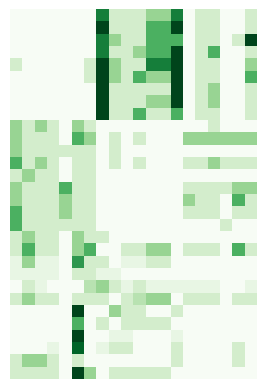

In [18]:
plt.imshow(WLP_Genes.loc[WLP.COGName[WLP.Category == "Metabolic"]].T.loc[BranchOrder], cmap='Greens', interpolation='nearest', vmin=0, vmax=5)
plt.axis('off')
plt.show()

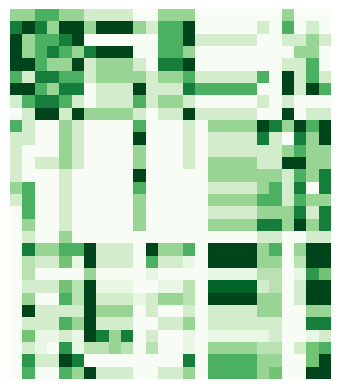

In [19]:
plt.imshow(WLP_Genes.loc[WLP.COGName[WLP.Category == "Bifurcating"]].T.loc[BranchOrder], cmap='Greens', interpolation='nearest', vmin=0, vmax=5)
plt.axis('off')
plt.show()

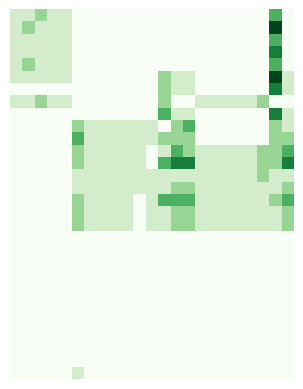

In [20]:
plt.imshow(WLP_Genes.loc[WLP.COGName[WLP.Category == "Ion-translocating"]].T.loc[BranchOrder], cmap='Greens', interpolation='nearest', vmin=0, vmax=5)
plt.axis('off')
#plt.colorbar()
plt.show()

# Done here

In [ ]:
WLP_Genes = WLP.merge(COGs, how = "left", left_on="COG", right_index= True).set_index("COGName").drop(["GeneName","Category","Group","COG"],axis=1).fillna(0)
WLP_Genes = WLP_Genes.loc[WLP.COGName[WLP.Category == "Metabolic"]]

Combined = Tree("../Data/input/CombninedSpeciesTreeETE.nw", format=1)# made using orthofinder, NCBI ID's are slightly different to the ones from the strains in EggNOG so that's corrected in the .nw file.
Combined.ladderize()

LeavesToKeep = ProposedClass[~ProposedClass.iloc[:,0].duplicated()]
LeavesToKeep.columns = ["TaxName"]
Combined.prune(NCBIRefIDs.index.union(LeavesToKeep.index))

#Add columns to link to the count matrix
LeavesToKeep["Feature"] = LeavesToKeep["TaxName"]
NCBIRefIDs["Feature"] = NCBIRefIDs.index

# Combine into single indexing dataframe
SpNamesID = pd.concat([LeavesToKeep,NCBIRefIDs])

# Rename the Asgard leaves so that they match the median counts instead of the chosen species
for lf in Combined.iter_leaves():
    if lf.name in list(LeavesToKeep.index):
        lf.name = LeavesToKeep.loc[lf.name][0]

# Add the counts to the specific leaves of the tree and change the names from TaxID to actual names
for lf in Combined.iter_leaves():
    lf.add_features(profile = WLP_Genes[lf.name].values)
    lf.add_features(deviation = [0 for x in range(len(WLP_Genes))])
    lf.add_face(ProfileFace(max_v=36.0, min_v=0.0, center_v=10.0, style='heatmap', colorscheme=4, width=len(WLP_Genes)*10, height=10), column=0, position="aligned")
    lf.name = SpNamesID.set_index("Feature")["TaxName"][lf.name]

description = list(WLP_Genes.index)
axisface = BarChartFace([0]*len(list(WLP_Genes.index)), width=len(WLP_Genes)*10, height=0, labels=list(WLP_Genes.index), max_value=1, scale_fsize=1)

ts = TreeStyle()
ts.draw_guiding_lines = True
ts.show_leaf_name = True
ts.aligned_foot.add_face(axisface, 0)
ts.show_scale = False

#Combined.render('../Data/output/heatmap.png', tree_style=ts, dpi = 75)
Combined.render("%%inline",tree_style=ts, dpi = 75)

In [ ]:
WLP_Genes = WLP.merge(COGs, how = "left", left_on="COG", right_index= True).set_index("COGName").drop(["GeneName","Category","Group","COG"],axis=1).fillna(0)
WLP_Genes = WLP_Genes.loc[WLP.COGName[WLP.Category == "Bifurcating"]]

Combined = Tree("../Data/input/CombninedSpeciesTreeETE.nw", format=1)# made using orthofinder, NCBI ID's are slightly different to the ones from the strains in EggNOG so that's corrected in the .nw file.
Combined.ladderize()

LeavesToKeep = ProposedClass[~ProposedClass.iloc[:,0].duplicated()]
LeavesToKeep.columns = ["TaxName"]
Combined.prune(NCBIRefIDs.index.union(LeavesToKeep.index))

#Add columns to link to the count matrix
LeavesToKeep["Feature"] = LeavesToKeep["TaxName"]
NCBIRefIDs["Feature"] = NCBIRefIDs.index

# Combine into single indexing dataframe
SpNamesID = pd.concat([LeavesToKeep,NCBIRefIDs])

# Rename the Asgard leaves so that they match the median counts instead of the chosen species
for lf in Combined.iter_leaves():
    if lf.name in list(LeavesToKeep.index):
        lf.name = LeavesToKeep.loc[lf.name][0]

# Add the counts to the specific leaves of the tree and change the names from TaxID to actual names
for lf in Combined.iter_leaves():
    lf.add_features(profile = WLP_Genes[lf.name].values)
    lf.add_features(deviation = [0 for x in range(len(WLP_Genes))])
    lf.add_face(ProfileFace(max_v=36.0, min_v=0.0, center_v=10.0, style='heatmap', colorscheme=4, width=len(WLP_Genes)*10, height=10), column=0, position="aligned")
    lf.name = SpNamesID.set_index("Feature")["TaxName"][lf.name]

description = list(WLP_Genes.index)
axisface = BarChartFace([0]*len(list(WLP_Genes.index)), width=len(WLP_Genes)*10, height=0, labels=list(WLP_Genes.index), max_value=1, scale_fsize=1)

ts = TreeStyle()
ts.draw_guiding_lines = False
ts.show_leaf_name = True
ts.aligned_foot.add_face(axisface, 0)
ts.show_scale = False

#Combined.render('../Data/output/heatmap.png', tree_style=ts, dpi = 75)
Combined.render("%%inline",tree_style=ts, dpi = 75)

In [ ]:
WLP_Genes = WLP.merge(COGs, how = "left", left_on="COG", right_index= True).set_index("COGName").drop(["GeneName","Category","Group","COG"],axis=1).fillna(0)
WLP_Genes = WLP_Genes.loc[WLP.COGName[WLP.Category == "Ion-translocating"]]

Combined = Tree("../Data/input/CombninedSpeciesTreeETE.nw", format=1)# made using orthofinder, NCBI ID's are slightly different to the ones from the strains in EggNOG so that's corrected in the .nw file.
Combined.ladderize()

LeavesToKeep = ProposedClass[~ProposedClass.iloc[:,0].duplicated()]
LeavesToKeep.columns = ["TaxName"]
Combined.prune(NCBIRefIDs.index.union(LeavesToKeep.index))

#Add columns to link to the count matrix
LeavesToKeep["Feature"] = LeavesToKeep["TaxName"]
NCBIRefIDs["Feature"] = NCBIRefIDs.index

# Combine into single indexing dataframe
SpNamesID = pd.concat([LeavesToKeep,NCBIRefIDs])

# Rename the Asgard leaves so that they match the median counts instead of the chosen species
for lf in Combined.iter_leaves():
    if lf.name in list(LeavesToKeep.index):
        lf.name = LeavesToKeep.loc[lf.name][0]

# Add the counts to the specific leaves of the tree and change the names from TaxID to actual names
for lf in Combined.iter_leaves():
    lf.add_features(profile = WLP_Genes[lf.name].values)
    lf.add_features(deviation = [0 for x in range(len(WLP_Genes))])
    lf.add_face(ProfileFace(max_v=36.0, min_v=0.0, center_v=10.0, style='heatmap', colorscheme=4, width=len(WLP_Genes)*10, height=10), column=0, position="aligned")
    lf.name = SpNamesID.set_index("Feature")["TaxName"][lf.name]

description = list(WLP_Genes.index)
axisface = BarChartFace([0]*len(list(WLP_Genes.index)), width=len(WLP_Genes)*10, height=0, labels=list(WLP_Genes.index), max_value=1, scale_fsize=1)

ts = TreeStyle()
ts.draw_guiding_lines = False
ts.show_leaf_name = True
ts.aligned_foot.add_face(axisface, 0)
ts.show_scale = False

#Combined.render('../Data/output/heatmap.png', tree_style=ts, dpi = 75)
Combined.render("%%inline",tree_style=ts, dpi = 75)

In [ ]:
OFOG_Annot[OFOG_Annot.COG == "arCOG03330"]

In [ ]:
OFOG_Annot[OFOG_Annot.COG == "COG1410"]

In [ ]:
COGsSpOI.loc["COG1410",COGsSpOI.loc["COG1410"] != 0]

In [ ]:
OFOG_Annot[OFOG_Annot.COG == "COG2037"]